<a href="https://colab.research.google.com/github/ShawnLiu119/Fraud_Detection_Credit/blob/v1.1/Feature_Engineer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Feature Engineer - Fraud Transaction**



#### Why we need engineer the features? <br>

Machine learning algorithms typically require numerical and ordered features. Numerical means that the type of the variable must be an integer or a real number. Ordered means that the order of the values of a variable is meaningful.

In this dataset, the only numerical and ordered features are the transaction amount and the fraud label. The date is a Panda timestamp, and therefore not numerical. The identifiers for the transactions, customers, and terminals are numerical but not ordered: it would not make sense to assume for example that the terminal with ID 3548 is 'bigger' or 'larger' than the terminal with ID 1983. Rather, these identifiers represent distinct 'entities', which are referred to as categorical features.

### Feature Transformation that are used relevant for payment card farud detection

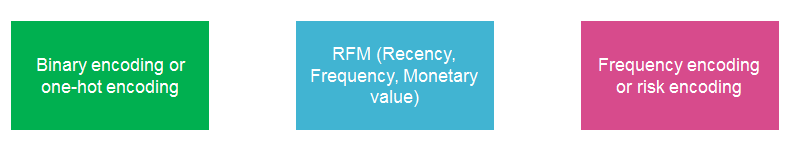

1. The first type of transformation involves the date/time variable, and consists in creating binary features that characterize potentially relevant periods. We will create two such features. **The first one will characterize whether a transaction occurs during a weekday or during the weekend. The second will characterize whether a transaction occurs during the day or the night.** These features can be useful since it has been observed in real-world datasets that fraudulent patterns differ between weekdays and weekends, and between the day and night.

2. The second type of transformation involves the **customer ID** and consists in creating features that characterize the **customer spending behaviors**. We will follow the **RFM (Recency, Frequency, Monetary value)** framework proposed in {cite}VANVLASSELAER201538, and keep track of the average spending amount and number of transactions for each customer and for **three window sizes**. This will lead to the creation of six new features.

3. The third type of transformation involves the **terminal ID** and consists in creating new features that characterize the **'risk' associated with the terminal. The risk will be defined as the average number of frauds that were observed on the terminal** for **three window sizes**. This will lead to the creation of three new features.

New features that would be generated
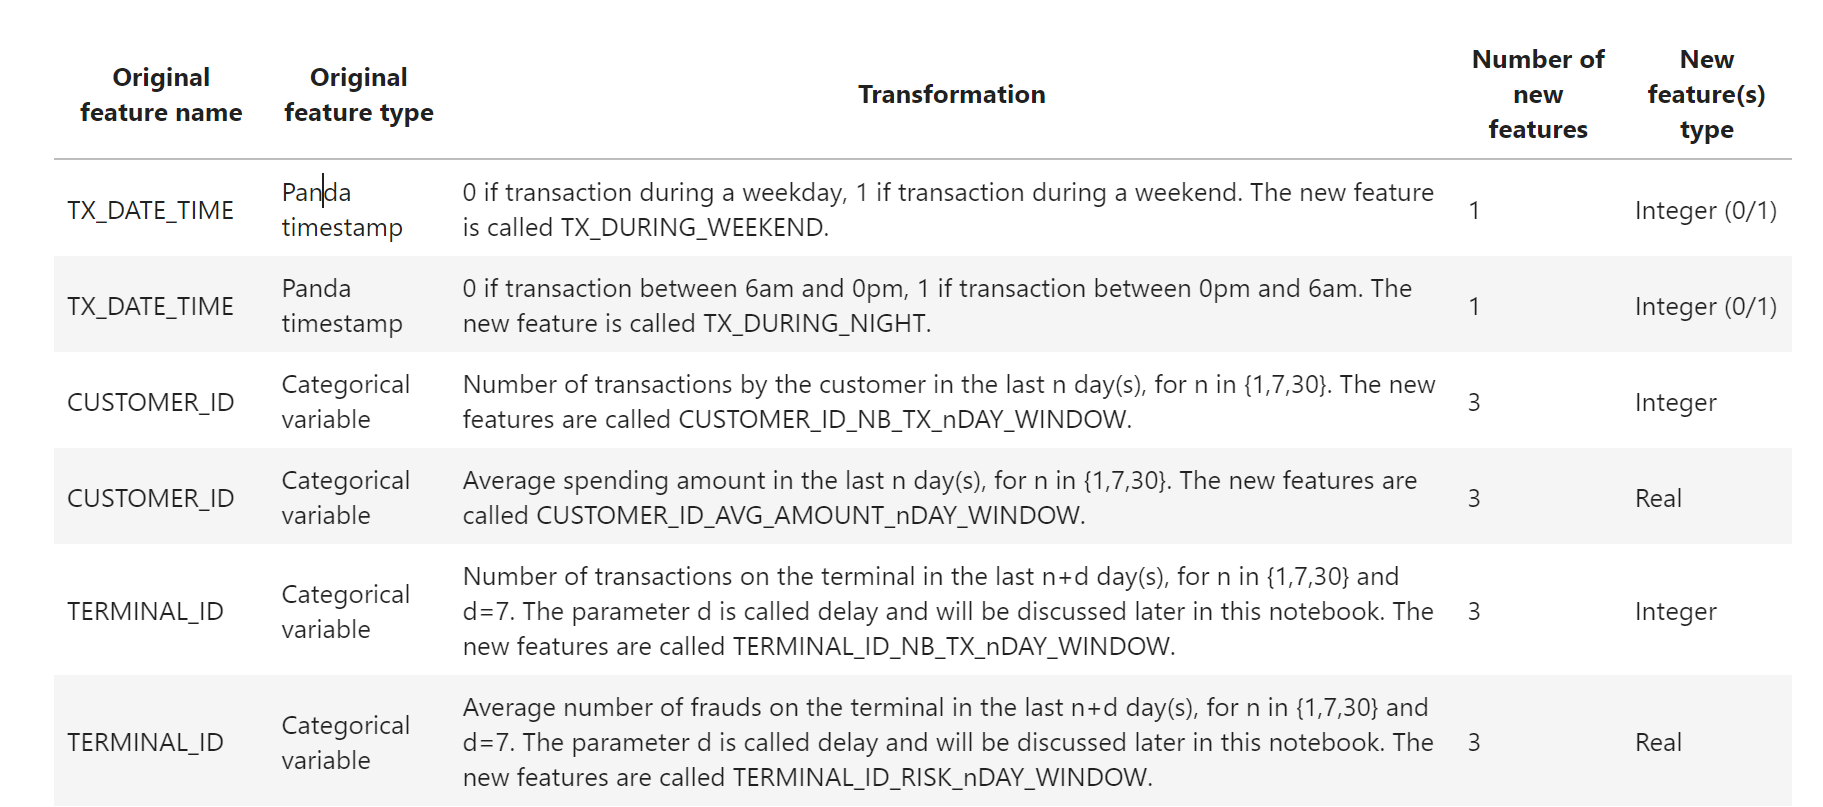

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Helper Function

In [ ]:
# General
import os
import pandas as pd
import numpy as np
import math
import sys
import time
import pickle
import json
import datetime
import random

#import sklearn
import sklearn
from sklearn import *

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

import graphviz
import xgboost

# For imbalanced learning
import imblearn

import warnings
warnings.filterwarnings('ignore')

#### read_from_files

In [ ]:
# Load a set of pickle files, put them together in a single DataFrame, and order them by time
# It takes as input the folder DIR_INPUT where the files are stored, and the BEGIN_DATE and END_DATE
def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):

    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)

    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True) #因为合并之后，原来的每个file的index都是从零开始，会产生重复，所以drop
    #  Note: -1 are missing values for real world data
    df_final=df_final.replace([-1],0)

    return df_final

In [ ]:
DIR_INPUT='/content/drive/MyDrive/kaggle_data/rawdata/content/simulated-data-raw/'

BEGIN_DATE = "2018-04-01"
END_DATE = "2018-09-30"


print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
CPU times: user 2.97 s, sys: 1.49 s, total: 4.46 s
Wall time: 9.84 s
1754155 transactions loaded, containing 16860 fraudulent transactions


In [ ]:
'2018-04-05.pkl' >= '2018-04-01.pkl' #文件名是可以比较的?

True

In [ ]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,272.96,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,405.37,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,724.31,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,314.37,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,248.53,634,0,0,0


In [ ]:
transactions_df.describe()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
count,1.754155e+06,1754155,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06
mean,8.770770e+05,2018-07-01 11:20:33.708572160,2.504011e+03,4.996733e+03,2.602398e+02,7.903234e+06,9.097260e+01,9.611465e-03,2.006607e-02
min,0.000000e+00,2018-04-01 00:00:31,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.385385e+05,2018-05-16 14:40:46.500000,1.252000e+03,2.502000e+03,9.493000e+01,3.940846e+06,4.500000e+01,0.000000e+00,0.000000e+00
50%,8.770770e+05,2018-07-01 11:11:10,2.506000e+03,4.994000e+03,2.148300e+02,7.902670e+06,9.100000e+01,0.000000e+00,0.000000e+00
75%,1.315616e+06,2018-08-16 08:01:01.500000,3.765000e+03,7.495000e+03,3.781000e+02,1.186566e+07,1.370000e+02,0.000000e+00,0.000000e+00
max,1.754154e+06,2018-09-30 23:59:57,4.999000e+03,9.999000e+03,1.301800e+04,1.581120e+07,1.820000e+02,1.000000e+00,3.000000e+00
std,5.063811e+05,NaN,1.445987e+03,2.886101e+03,2.129396e+02,4.565172e+06,5.283709e+01,9.756583e-02,2.141324e-01
